In [1]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
from tools.visualization import Demo

%matplotlib widget

2


In [2]:
def open_image(img_folder, img_name, img_size):
    img_path = os.path.join(img_folder, img_name)
    pil_img = Image.open(img_path).convert('RGB')
    image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
    _, _, h, w = image.shape
    image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
    return pil_img, image, h, w

In [3]:
models_list = {
    "SSD-1B":'segmind/SSD-1B',
    "SSD-vega":'segmind/Segmind-vega',
    "SD1.4": "CompVis/stable-diffusion-v1-4",
    "DINOv1":'vit_base_patch16_224.dino',
    "DINOv2-L":'vit_large_patch14_dinov2',
    "CLIP-VIT-L":'vit_large_patch14_clip_quickgelu_224',
    "SigLIP-L":'vit_large_patch16_siglip_256'
    }

#### __Load Feature Extractor__

In [4]:
from tools.features_extraction import FeatureExtractor
from tools.ldm import LdmExtractor

model_name = "SSD-1B" # Change the model name with a key in models_list
img_size = 1024

if "SD" in model_name:
    extractor = LdmExtractor(model_name=model_name)
else:
    extractor = FeatureExtractor(models_list[model_name], img_size=img_size)

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


#### __Image Patch-Level Alignement__

In [5]:
examples = [
    "2007_001239.png", # 3 dogs
    "2007_000925.png", # 2 sheeps
    "2007_005915.png", # sheep and lamb
    "2009_000032.png", # old plane
    "2008_001895.png", # dog
    "2009_003640.png", # bird
    "2010_003132.png", # hydroplane
    "2010_003473.png", # owl
    "2010_005788.png", # 4 sheeps
    ]

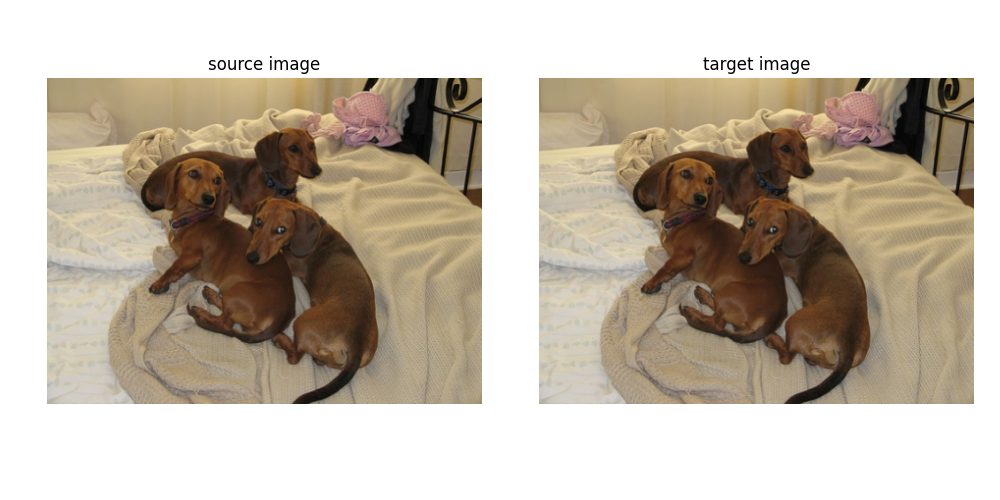

In [6]:
img_folder = "./assets/resized_imgs"
img_name = examples[0]
img_path = os.path.join(img_folder, img_name)

pil_img, image, h, w = open_image(img_folder, img_name, img_size)

if "SD" in model_name:
    features = extractor(image, step=50)
    # Output features from the final self-attention block of the UNet encoder
    features = features.reshape(1, img_size//32, img_size//32, -1).permute(0, 3, 1, 2)
else:
    features = extractor(image)
    features = features[-1][0]

demo = Demo([pil_img, pil_img], torch.cat([features, features], dim=0), (h, w))
demo.plot_img_pairs(fig_size=5, show_marker=True)

#### __Inter Image Patch-Level Alignment__

In [7]:
pairs_list = [("2007_001239.png", "2008_001895.png"), # 3 dogs vs 1 dog
         ("2010_005788.png", "2007_005915.png"), # 4 sheeps vs sheep and lamb
         ("2010_005788.png", "2007_000925.png"), # 4 sheeps vs 2 sheeps
         ("2010_003473.png", "2009_003640.png"), # owl vs bird
         ("2009_000032.png", "2010_003132.png"), # old plane vs hydroplane
         ] 

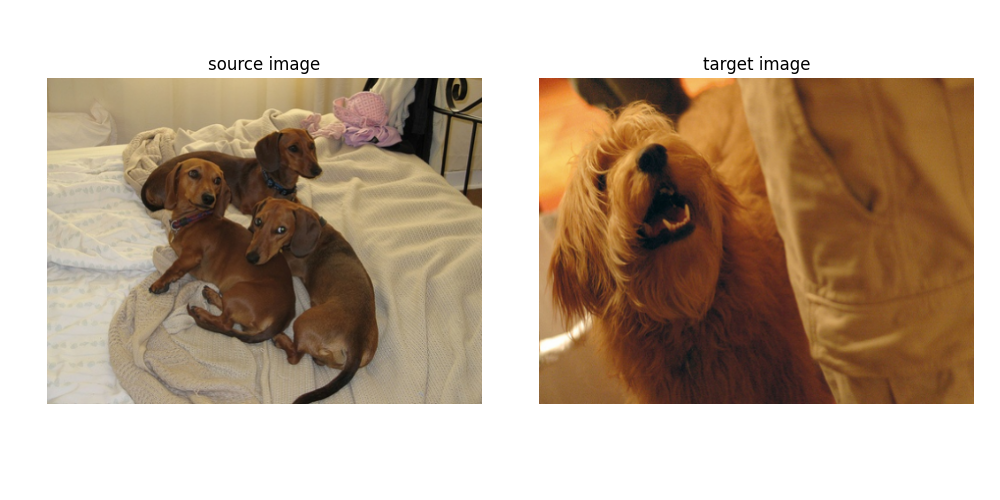

In [8]:
img_folder = "./assets/resized_imgs"
pair = pairs_list[0] # Select the image pair in pairs_list
img_name1, img_name2 = pair[0], pair[1]

pil_img1, image1, h, w = open_image(img_folder, img_name1, img_size)
pil_img2, image2, _, _ = open_image(img_folder, img_name2, img_size)

if "SD" in model_name:
    features = []
    # loop for memory limited gpus
    for img in [image1, image2]:
        img_features = extractor(img, step=50)
        img_features = img_features.reshape(1, img_size//32, img_size//32, -1).permute(0, 3, 1, 2)
        features.append(img_features)
    features = torch.cat(features, dim=0)
else:
    features = extractor(torch.cat([image1, image2], dim=0))
    features = features[-1][0]
        
demo = Demo([pil_img1, pil_img2], features, (h, w))
demo.plot_img_pairs(fig_size=5, show_marker=False)